# Librerías

In [1]:
# Para la importación de los datos desde Socrata
from sodapy  import Socrata

from datetime   import datetime
import pandas   as pd
import numpy    as np
import warnings
import scipy.stats as stats
import math

#Para gráficos y mapas de calor
import seaborn            as sb
import matplotlib.pyplot  as plt
import plotly.graph_objs  as go

#Para la imputación de los datos
from sklearn.impute     import SimpleImputer
from sklearn.compose    import ColumnTransformer
import missingno        as msno

#Para el pre-procesamiento de los datos
from sklearn.preprocessing      import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection  import SelectKBest, chi2

# Suprimir los warnings específicos
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Lectura


In [2]:
#inicio = datetime.now()
#print(f"Hora inicial: {inicio.strftime('%Y-%m-%d %H:%M:%S')}")

#client = Socrata("www.datos.gov.co", None, timeout=60)
#DATASET = "kgxf-xxbe"

#limit = 50_000
#offset = 0
#frames = []

#while True:
#    results = client.get(DATASET, limit=limit, offset=offset)
#    if not results:
#        break
#    frames.append(pd.DataFrame.from_records(results))
#    offset += limit

#saber11_df = pd.concat(frames, ignore_index=True)

# ----------------------------------------
#fin = datetime.now()
#print(f"Hora final:   {fin.strftime('%Y-%m-%d %H:%M:%S')}")
#print(f"Duración total: {fin - inicio}")
#print(f"Filas descargadas: {saber11_df.shape[0]:,}")
# ----------------------------------------


El conjunto de datos corresponde a los Resultados únicos de la prueba Saber 11, publicados por el ICFES y disponibles en el portal Datos Abiertos de Colombia.
Contiene información detallada sobre los estudiantes que presentaron la prueba, las características del colegio y variables familiares y socioeconómicas asociadas al desempeño académico.


La versión empleada fue obtenida mediante la API pública de Socrata, lo que permitió descargar el total de registros (7.109.704 observaciones)

En caso de que la información extraida por la API no este disponible , disponemos de la siguiente celda para poder cargar los datos directamente de un archivo ".parquet".

- para poder hacer uso de esta alternativa debemos descomentar la linea de codigo y ejecutar la celda 

In [3]:
saber11_df = pd.read_parquet("saber11_completo.parquet")
saber11_df.shape[0]

7109704

Para poder identificar el tipo de dato de las columnas y si tienen alguna novedad que debamos tener en cuenta para tratar los datos correctamente  utilizaremos el comando ".info()" para ver el tipo de dato de cada campo .

- Encontramos que todos los datos cargados del dataframe son de tipo "object" 
- Por lo que mas adelante se tendra que modificar el tipo de dato en algunos campos para poder tratarlos correctamente

In [3]:
saber11_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109704 entries, 0 to 7109703
Data columns (total 51 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   periodo                        object
 1   estu_tipodocumento             object
 2   estu_consecutivo               object
 3   cole_area_ubicacion            object
 4   cole_bilingue                  object
 5   cole_calendario                object
 6   cole_caracter                  object
 7   cole_cod_dane_establecimiento  object
 8   cole_cod_dane_sede             object
 9   cole_cod_depto_ubicacion       object
 10  cole_cod_mcpio_ubicacion       object
 11  cole_codigo_icfes              object
 12  cole_depto_ubicacion           object
 13  cole_genero                    object
 14  cole_jornada                   object
 15  cole_mcpio_ubicacion           object
 16  cole_naturaleza                object
 17  cole_nombre_establecimiento    object
 18  cole_nombre_sede      

El dataset cuenta con 51 columnas, que abarcan:

Identificación y datos personales del estudiante: tipo de documento, género, fecha de nacimiento, departamento y municipio de residencia.
Información del establecimiento educativo: nombre, código DANE, ubicación geográfica, calendario, carácter, jornada y naturaleza del colegio.

Contexto familiar: nivel educativo de los padres, número de personas en el hogar y acceso a bienes como computador, internet o lavadora.

Resultados académicos: puntajes por área (lectura crítica, matemáticas, ciencias naturales, sociales e inglés) y el puntaje global.

In [4]:
saber11_df.head(4)

,periodo,estu_tipodocumento,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
0,20131,CR,SB11201310000414,URBANO,N,B,ACADÉMICO,311848000812,311848000812,11,11001,022574,BOGOTA,FEMENINO,COMPLETA,BOGOTÁ D.C.,NO OFICIAL,GIMN FEMENINO,GIMN FEMENINO,S,11,11001,11,11001,BOGOTÁ,BOGOTÁ,PUBLICAR,ESTUDIANTE,08/08/1994,F,BOGOTÁ D.C.,BOGOTÁ D.C.,COLOMBIA,COLOMBIA,N,Cuatro,Educación profesional completa,Educación profesional completa,Estrato 6,Cuatro,Si,Si,Si,Si,B+,94,88,None,None,None,None
1,20194,TI,SB11201940464873,RURAL,N,A,TÉCNICO/ACADÉMICO,141016000305,241016000342,41,41016,194878,HUILA,MIXTO,COMPLETA,AIPE,OFICIAL,INSTITUCION EDUCATIVA JESUS MARIA AGUIRRE CHARRY,DINDAL,N,41,41016,41,41016,HUILA,HUILA,PUBLICAR,ESTUDIANTE,15/02/2003,F,AIPE,AIPE,COLOMBIA,COLOMBIA,N,Dos,Postgrado,Primaria completa,Estrato 2,1 a 2,No,Si,Si,Si,B1,71,66,70,65,69,339
2,20194,TI,SB11201940464873,RURAL,N,A,TÉCNICO/ACADÉMICO,141016000305,241016000342,41,41016,194878,HUILA,MIXTO,COMPLETA,AIPE,OFICIAL,INSTITUCION EDUCATIVA JESUS MARIA AGUIRRE CHARRY,DINDAL,N,41,41016,41,41016,HUILA,HUILA,PUBLICAR,ESTUDIANTE,15/02/2003,F,AIPE,AIPE,COLOMBIA,COLOMBIA,N,Dos,Postgrado,Primaria completa,Estrato 2,1 a 2,No,Si,Si,Si,B1,71,66,70,65,69,339
3,20122,TI,SB11201220204399,URBANO,N,A,TÉCNICO/ACADÉMICO,163130000718,163130000718,63,63130,013029,QUINDIO,MIXTO,MAÑANA,CALARCÁ,OFICIAL,INSTITUCION EDUCATIVA ANTONIO NARIÑO,ANTONIO NARIÑO,S,63,63130,63,63130,QUINDIO,QUINDIO,PUBLICAR,ESTUDIANTE,20/05/1996,F,CALARCÁ,CALARCÁ,COLOMBIA,COLOMBIA,N,Dos,Secundaria (Bachillerato) incompleta,No sabe,Estrato 1,Cuatro,No,Si,Si,No,A1,48,45,None,None,None,None


In [4]:
# Definir las columnas que deben ser únicas por estudiante y periodo
columnas_unicas = ['periodo', 'estu_consecutivo']

# Contar duplicados (todas las filas repetidas excepto la primera ocurrencia)
duplicados = saber11_df.duplicated(subset=columnas_unicas, keep='first').sum()

print(f"Filas duplicadas encontradas según {columnas_unicas}: {duplicados:,}")

# Tamaño original
print(f"Tamaño original del DataFrame: {saber11_df.shape[0]:,} filas, {saber11_df.shape[1]} columnas")

# Eliminar duplicados
saber11_df = saber11_df.drop_duplicates(subset=columnas_unicas, keep='first')

# Tamaño final
print(f"Tamaño después de eliminar duplicados: {saber11_df.shape[0]:,} filas, {saber11_df.shape[1]} columnas")

# Confirmar que ya no existan duplicados
restantes = saber11_df.duplicated(subset=columnas_unicas, keep=False).sum()
print(f"Duplicados restantes: {restantes}")

Filas duplicadas encontradas según ['periodo', 'estu_consecutivo']: 1,388,971
Tamaño original del DataFrame: 7,109,704 filas, 51 columnas
Tamaño después de eliminar duplicados: 5,720,733 filas, 51 columnas
Duplicados restantes: 0


In [5]:
# Cálculo de la edad del estudiante

# 1. Convertir la fecha de nacimiento a datetime - Como hay unas fechas imposibles, se incluye un manejo de errores.
saber11_df['estu_fechanacimiento'] = pd.to_datetime(
    saber11_df['estu_fechanacimiento'],
    format='%d/%m/%Y',
    errors='coerce'
)

# 2. Separar año y trimestre - esto se utiliza para poder calcular la edad de presentación de la prueba de forma más acertada.
saber11_df['anio'] = saber11_df['periodo'].astype(str).str[:4].astype(int)
saber11_df['trimestre'] = saber11_df['periodo'].astype(str).str[-1].astype(int)

# 3. Mapear trimestre a fecha de corte
mapa_fechas = {1: (3, 31), 2: (6, 30), 3: (9, 30), 4: (12, 31)}

def calcular_fecha_corte(row):
    mes, dia = mapa_fechas[row['trimestre']]
    return datetime(row['anio'], mes, dia)

saber11_df['fecha_corte'] = saber11_df.apply(calcular_fecha_corte, axis=1)

# 4. Calcular edad en años
def calcular_edad(row):
    edad = row['fecha_corte'].year - row['estu_fechanacimiento'].year
    # Restar un año si aún no ha cumplido años en la fecha de corte
    if (row['fecha_corte'].month, row['fecha_corte'].day) < (row['estu_fechanacimiento'].month, row['estu_fechanacimiento'].day):
        edad -= 1
    return edad

saber11_df['estu_edad_anios'] = saber11_df.apply(calcular_edad, axis=1)

# 5. Eliminar columnas temporales
saber11_df.drop(columns=['fecha_corte', 'anio', 'trimestre'], inplace=True)

In [6]:
# Quitar columnas que incluyen códigos de establecimiento o geografía, que son redundantes

cols_a_eliminar = [
    'estu_consecutivo', 'estu_tipodocumento', 'cole_cod_dane_establecimiento',
    'cole_cod_dane_sede', 'cole_cod_depto_ubicacion', 'cole_cod_mcpio_ubicacion',
    'cole_nombre_establecimiento', 'cole_nombre_sede', 'estu_cod_depto_presentacion',
    'estu_cod_mcpio_presentacion', 'estu_cod_reside_depto', 'estu_cod_reside_mcpio',
    'estu_fechanacimiento', 'desemp_ingles', 'cole_codigo_icfes'
]

saber11_df = saber11_df.drop(columns=[c for c in cols_a_eliminar if c in saber11_df.columns])

In [7]:
# Crear un diccionario para clasificar las variables
clasificacion_variables = {}

# Iterar sobre los nombres de las columnas
for columna in saber11_df.columns:
    # Extraer el prefijo (el primer pedazo antes del guion bajo "_")
    prefijo = columna.split('_')[0]

    # Agregar la columna al diccionario basado en el prefijo
    if prefijo not in clasificacion_variables:
        clasificacion_variables[prefijo] = []
    clasificacion_variables[prefijo].append(columna)

# Mostrar el diccionario resultante
for key, value in clasificacion_variables.items():
    print(f"{key}: {value}")

periodo: ['periodo']
cole: ['cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_depto_ubicacion', 'cole_genero', 'cole_jornada', 'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_sede_principal']
estu: ['estu_depto_presentacion', 'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_estudiante', 'estu_genero', 'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad', 'estu_pais_reside', 'estu_privado_libertad', 'estu_edad_anios']
fami: ['fami_cuartoshogar', 'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora']
punt: ['punt_ingles', 'punt_matematicas', 'punt_sociales_ciudadanas', 'punt_c_naturales', 'punt_lectura_critica', 'punt_global']


In [8]:
# Identificar las columnas con prefijo 'punt'
cols_punt = clasificacion_variables.get('punt', [])

# Reemplazar texto "None" por NaN y convertir a numérico
for col in cols_punt:
    saber11_df[col] = (
        saber11_df[col]
        .replace("None", np.nan)               # reemplaza "None" por NaN
        .astype(str)                           # asegura tipo string
        .str.replace('[\$,]', '', regex=True)  # limpia símbolos si existen
        .replace('nan', np.nan)                # por si quedan strings "nan"
        .apply(pd.to_numeric, errors='coerce') # convierte a numérico
    )

# Verificar el resultado
saber11_df[cols_punt].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5720733 entries, 0 to 7109703
Data columns (total 6 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   punt_ingles               float64
 1   punt_matematicas          float64
 2   punt_sociales_ciudadanas  float64
 3   punt_c_naturales          float64
 4   punt_lectura_critica      float64
 5   punt_global               float64
dtypes: float64(6)
memory usage: 305.5 MB


In [9]:
# Clasificar las columnas en numéricas y categóricas
numericas = saber11_df.select_dtypes(include=[np.number]).columns.tolist()
categoricas = saber11_df.select_dtypes(include=[object]).columns.tolist()

# Mostrar las columnas clasificadas
print("Columnas numéricas:")
print(numericas)

print("\nColumnas categóricas:")
print(categoricas)

Columnas numéricas:
['punt_ingles', 'punt_matematicas', 'punt_sociales_ciudadanas', 'punt_c_naturales', 'punt_lectura_critica', 'punt_global', 'estu_edad_anios']

Columnas categóricas:
['periodo', 'cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_depto_ubicacion', 'cole_genero', 'cole_jornada', 'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_sede_principal', 'estu_depto_presentacion', 'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_estudiante', 'estu_genero', 'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad', 'estu_pais_reside', 'estu_privado_libertad', 'fami_cuartoshogar', 'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora']


In [10]:
saber11_df = saber11_df.dropna(subset=['punt_global'])

saber11_df = saber11_df.dropna(subset=['punt_ingles'])

In [11]:
# Calcular estadísticas básicas solo para las columnas numéricas
resumen_numerico = pd.DataFrame({
    'mean': saber11_df[numericas].mean(numeric_only=True),
    'std': saber11_df[numericas].std(numeric_only=True),
    'min': saber11_df[numericas].min(numeric_only=True),
    'max': saber11_df[numericas].max(numeric_only=True),
    'median': saber11_df[numericas].median(numeric_only=True),
})

# Contar valores faltantes
resumen_numerico['missing_count'] = saber11_df[numericas].isna().sum()

# Porcentaje de faltantes sobre el total
resumen_numerico['missing_pct'] = (
    saber11_df[numericas].isna().mean() * 100
).round(2)

# Mostrar las primeras filas
resumen_numerico

,mean,std,min,max,median,missing_count,missing_pct
punt_ingles,50.623766,12.355795,0.0,100.0,49.0,0,0.00
punt_matematicas,50.740744,11.955758,0.0,100.0,50.0,0,0.00
punt_sociales_ciudadanas,49.428406,11.537753,0.0,100.0,49.0,0,0.00
punt_c_naturales,50.526647,10.498473,0.0,100.0,50.0,0,0.00
punt_lectura_critica,52.053779,10.275786,0.0,100.0,52.0,0,0.00
punt_global,253.413146,49.820166,0.0,495.0,250.0,0,0.00
estu_edad_anios,17.558935,3.777806,-84.0,131.0,17.0,5346,0.16


In [12]:
# Manejo de edades

#Definir rango de edades aceptado - mantenemos valores pequeños y altos porque puede haber casos atípicos reales.
rango_min, rango_max = 10, 100

# Se asigna NaN a todos los que están por fuera de dicho rango
saber11_df.loc[
    (saber11_df['estu_edad_anios'] < rango_min) | 
    (saber11_df['estu_edad_anios'] > rango_max),
    'estu_edad_anios'
] = np.nan

# Se imputan los NaN con la mediana
mediana_edad = saber11_df['estu_edad_anios'].median()
saber11_df['estu_edad_anios'].fillna(mediana_edad, inplace=True)

saber11_df['estu_edad_anios'].describe()

count    3.393651e+06
mean     1.756778e+01
std      3.645997e+00
min      1.000000e+01
25%      1.600000e+01
50%      1.700000e+01
75%      1.800000e+01
max      1.000000e+02
Name: estu_edad_anios, dtype: float64

<Axes: >

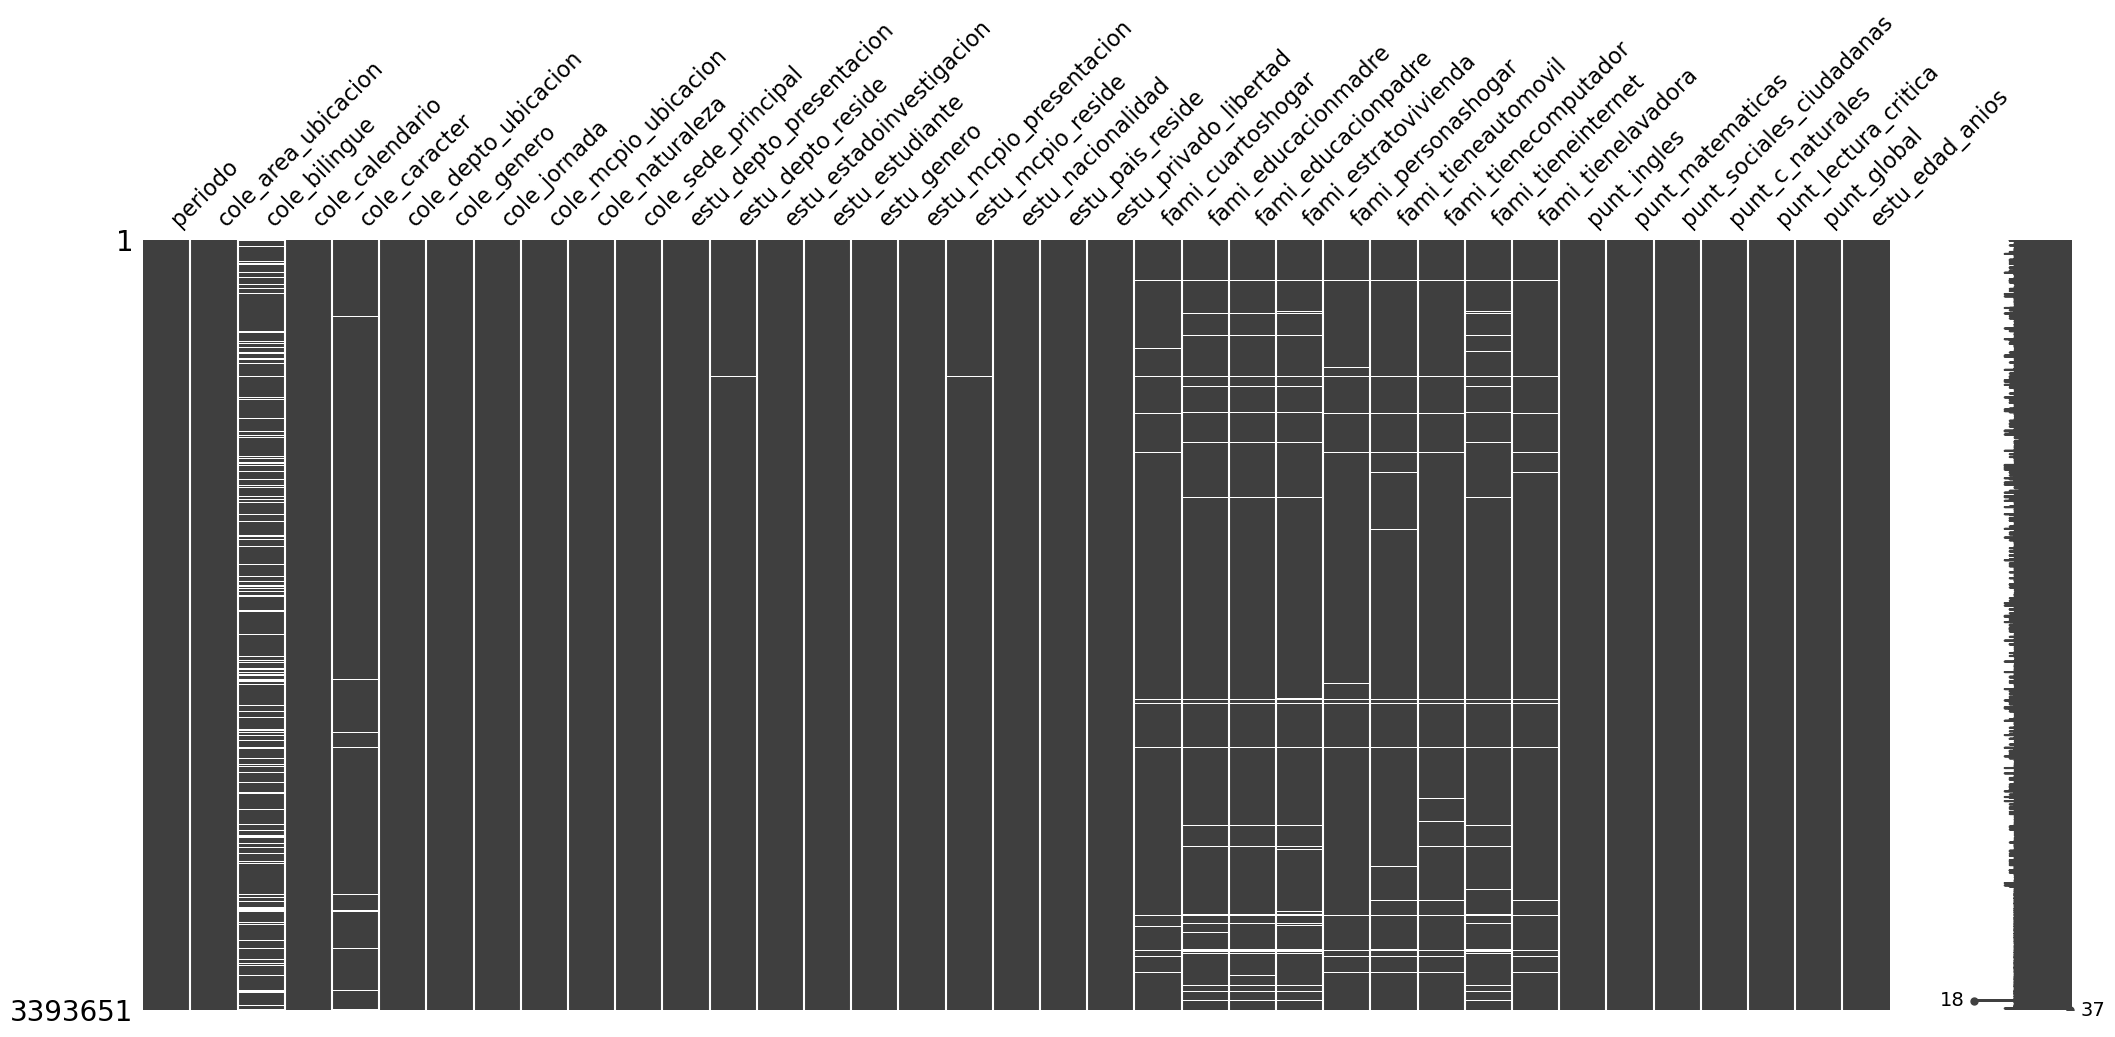

In [13]:
msno.matrix(saber11_df)

In [14]:
# Calcular conteo y porcentaje de faltantes en columnas categóricas
faltantes_cat = (
    saber11_df[categoricas]
    .isna()
    .sum()
    .reset_index()
    .rename(columns={"index": "columna", 0: "missing_count"})
)

faltantes_cat["missing_pct"] = 100 * faltantes_cat["missing_count"] / len(saber11_df)

# Ordenar de mayor a menor porcentaje de faltantes
faltantes_cat = faltantes_cat.sort_values(by="missing_pct", ascending=False).reset_index(drop=True)

# Mostrar las primeras filas
print(faltantes_cat.head(30))  # puedes ajustar el número

                     columna  missing_count  missing_pct
0              cole_bilingue         480877    14.169901
1       fami_estratovivienda         107490     3.167385
2         fami_tieneinternet          98634     2.906427
3        fami_educacionpadre          96523     2.844223
4        fami_educacionmadre          96486     2.843133
5        fami_tieneautomovil          62610     1.844916
6              cole_caracter          60265     1.775816
7         fami_personashogar          59771     1.761259
8          fami_cuartoshogar          59011     1.738865
9       fami_tienecomputador          58991     1.738275
10        fami_tienelavadora          58256     1.716617
11               estu_genero           3085     0.090905
12         estu_depto_reside           1675     0.049357
13         estu_mcpio_reside           1675     0.049357
14   estu_depto_presentacion             86     0.002534
15   estu_mcpio_presentacion             86     0.002534
16       cole_area_ubicacion   

  cole_bilingue    count        mean  median        std
0             N  2850113  254.072731   251.0  48.966116
1    No_reporta   480877  244.255643   240.0  48.886747
2             S    62661  293.689280   301.0  68.856198


<Figure size 800x500 with 0 Axes>

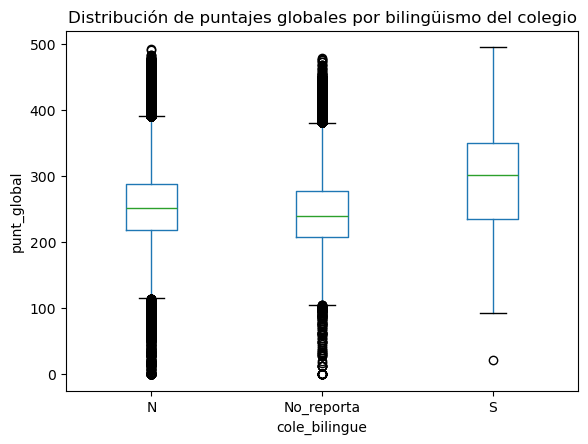

In [16]:
# Reemplazar NaN por categoría explícita
saber11_df["cole_bilingue"] = saber11_df["cole_bilingue"].fillna("No_reporta")

# Promedio, mediana y desviación estándar del puntaje global por categoría
resumen_bilingue = (
    saber11_df.groupby("cole_bilingue")["punt_global"]
    .agg(["count", "mean", "median", "std"])
    .reset_index()
)

print(resumen_bilingue)


plt.figure(figsize=(8,5))
saber11_df.boxplot(column="punt_global", by="cole_bilingue", grid=False)
plt.title("Distribución de puntajes globales por bilingüismo del colegio")
plt.suptitle("")
plt.xlabel("cole_bilingue")
plt.ylabel("punt_global")
plt.show()

In [17]:
from scipy.stats import mannwhitneyu

grupo_n = saber11_df.loc[saber11_df["cole_bilingue"] == "N", "punt_global"].dropna()
grupo_nr = saber11_df.loc[saber11_df["cole_bilingue"] == "No_reporta", "punt_global"].dropna()

stat, p = mannwhitneyu(grupo_n, grupo_nr)
print(f"Estadístico U = {stat:.3f}, p-valor = {p:.4f}")

Estadístico U = 765528602907.000, p-valor = 0.0000


In [18]:
# Mostrar tamaño original
print("Tamaño original del DataFrame:", saber11_df.shape)

# Eliminar todas las filas que tengan al menos un dato faltante
saber11_df = saber11_df.dropna()

# Mostrar tamaño final
print("Tamaño después de eliminar filas con algún valor faltante:", saber11_df.shape)

# Verificar si aún quedan valores faltantes
print("\nValores faltantes restantes por columna:")
print(saber11_df.isna().sum().sum(), "en total")

Tamaño original del DataFrame: (3393651, 37)
Tamaño después de eliminar filas con algún valor faltante: (3172551, 37)

Valores faltantes restantes por columna:
0 en total


<Axes: >

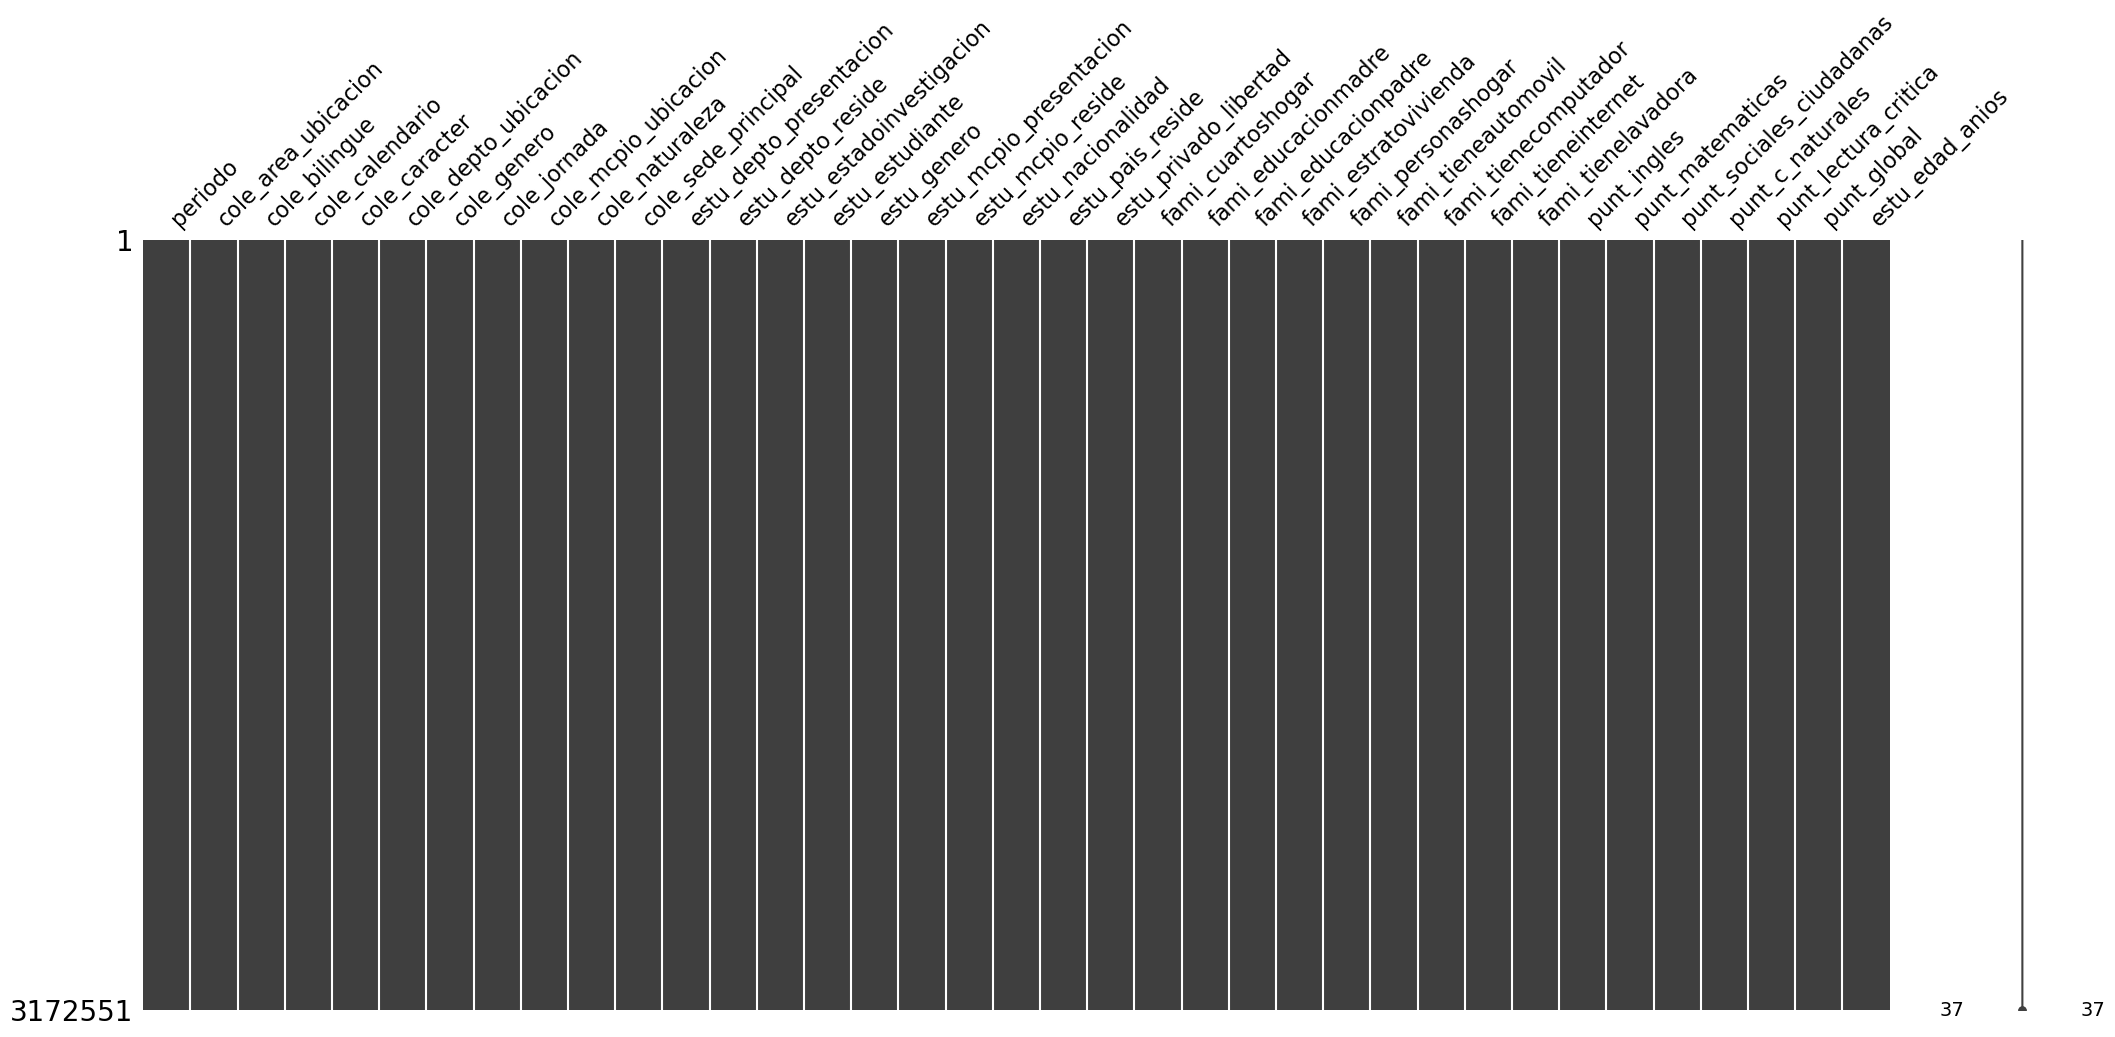

In [19]:
msno.matrix(saber11_df)

In [20]:
# Guardar el DataFrame limpio
saber11_df.to_parquet("saber11_limpio.parquet", index=False, engine="pyarrow")

la mayoría de las variables presentan una completitud superior al 95 %, lo que indica una buena calidad general del conjunto de datos.
Los valores faltantes más relevantes se concentran en:

cole_bilingue con un 12,89 % de registros vacíos.
Variables familiares como fami_educacionmadre, fami_educacionpadre, fami_estratovivienda y fami_tieneinternet, con porcentajes entre 2 % y 3 %.

Las variables de resultados punt_sociales_ciudadanas, punt_c_naturales, punt_lectura_critica y punt_global, con aproximadamente 36,7 % de valores faltantes, lo que sugiere que una parte importante de los registros no cuenta con calificación completa.

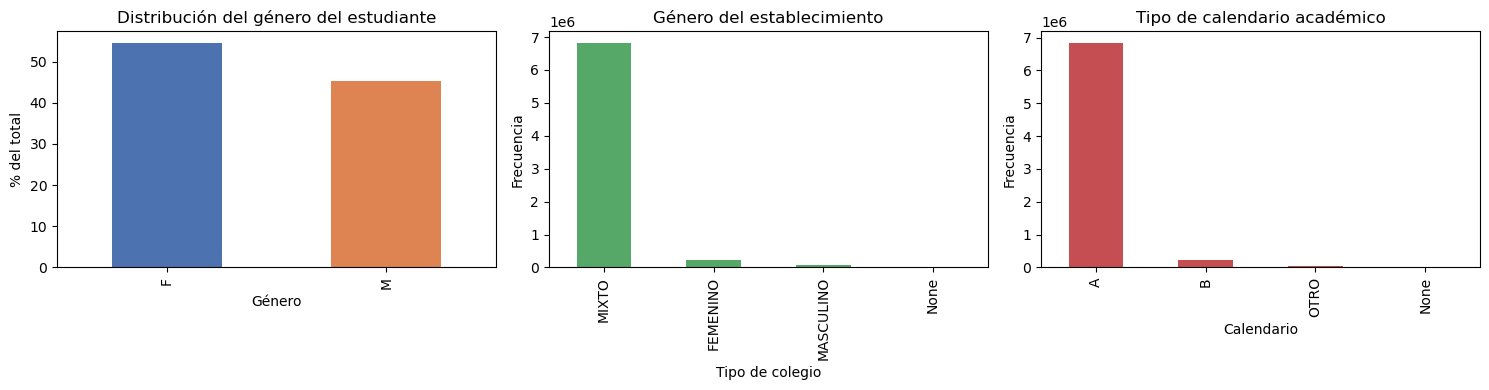

In [ ]:
plt.figure(figsize=(15,4))

#  Género del estudiante
plt.subplot(1,3,1)
saber11_df['estu_genero'].value_counts(normalize=True).sort_values(ascending=False).mul(100).plot(
    kind='bar', color=['#4C72B0','#DD8452'])
plt.title('Distribución del género del estudiante')
plt.ylabel('% del total')
plt.xlabel('Género')

# Género del colegio
plt.subplot(1,3,2)
saber11_df['cole_genero'].value_counts(dropna=False).plot(
    kind='bar', color='#55A868')
plt.title('Género del establecimiento')
plt.ylabel('Frecuencia')
plt.xlabel('Tipo de colegio')

# Calendario escolar
plt.subplot(1,3,3)
saber11_df['cole_calendario'].value_counts(dropna=False).plot(
    kind='bar', color='#C44E52')
plt.title('Tipo de calendario académico')
plt.ylabel('Frecuencia')
plt.xlabel('Calendario')

plt.tight_layout()
plt.show()



En la distribución por género del estudiante, se observa una ligera mayoría de mujeres, que representan algo más del 50 % de la muestra. Esto refleja una participación equilibrada entre ambos géneros en la prueba Saber 11, sin diferencias marcadas en la cobertura.

En cuanto al género del establecimiento educativo, la gran mayoría de los estudiantes proviene de colegios mixtos, mientras que los establecimientos exclusivamente femeninos o masculinos son minoritarios. Este patrón es coherente con la tendencia nacional hacia la educación mixta.

Respecto al tipo de calendario académico, predomina el calendario A, que agrupa a la mayoría de instituciones oficiales del país. El calendario B tiene una presencia reducida, asociada principalmente a colegios privados bilingües o de orientación internacional.


## Analisis sociodemografico

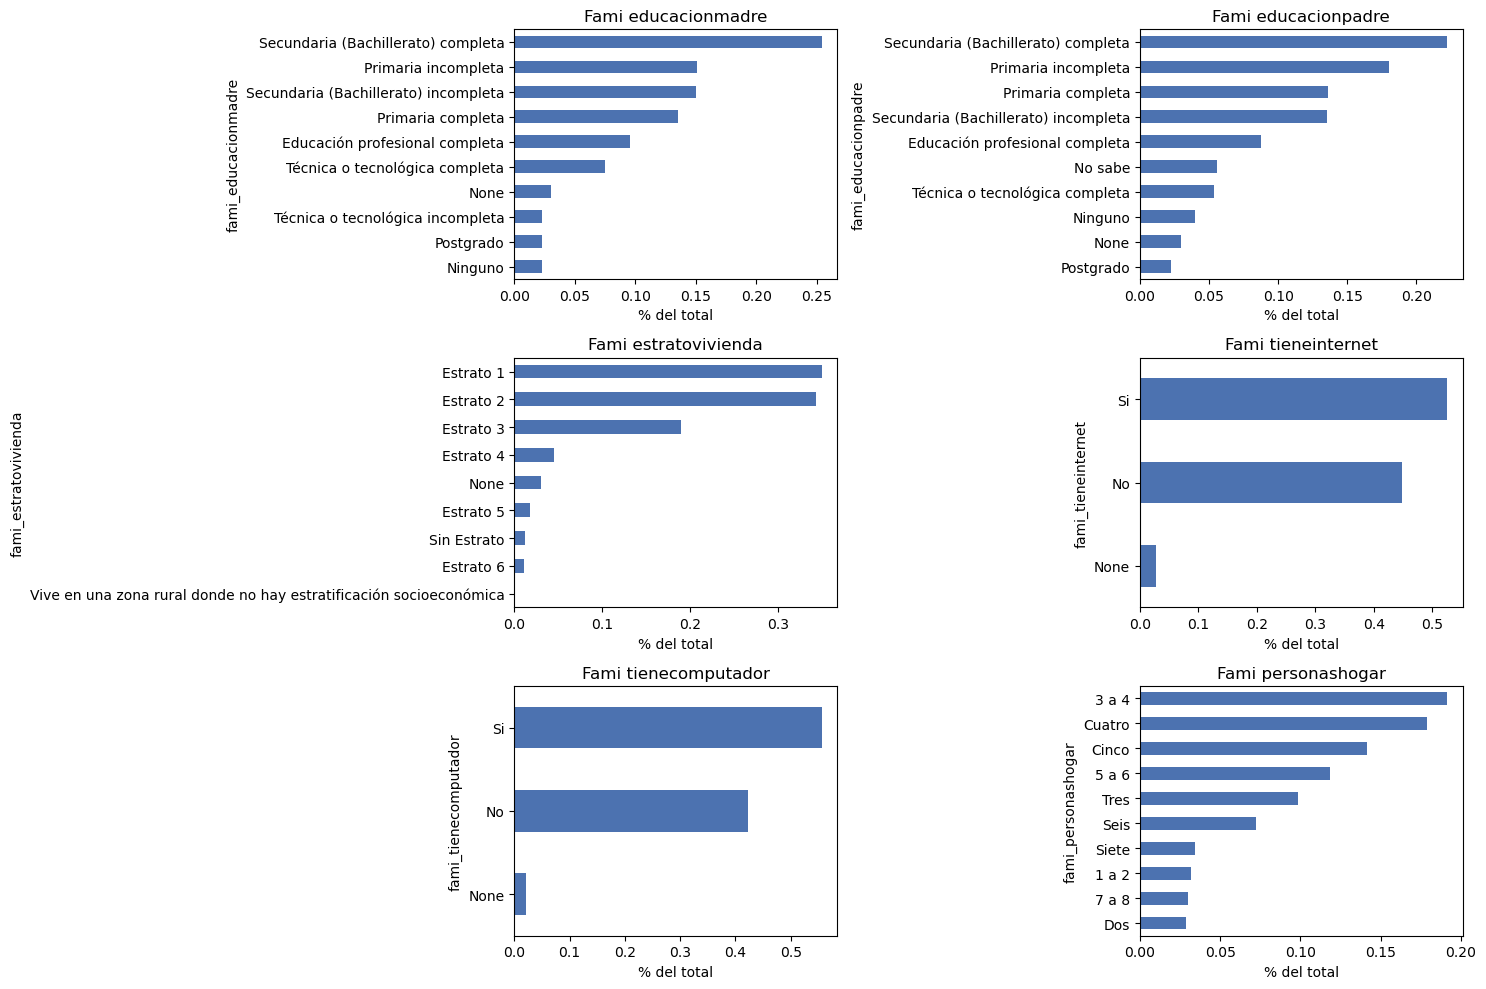

In [ ]:
cols = [
    "fami_educacionmadre",
    "fami_educacionpadre",
    "fami_estratovivienda",
    "fami_tieneinternet",
    "fami_tienecomputador",
    "fami_personashogar"
]

plt.figure(figsize=(15,10))
for i, col in enumerate(cols, 1):
    plt.subplot(3,2,i)
    saber11_df[col].value_counts(normalize=True, dropna=False).head(10).sort_values(ascending=True).plot(
        kind='barh', color='#4C72B0')
    plt.title(col.replace("_"," ").capitalize())
    plt.xlabel('% del total')
plt.tight_layout()
plt.show()


En el entorno familiar se observa que la mayoría de los padres y madres alcanzaron como máximo la educación secundaria completa, mientras que una proporción menor logró niveles técnicos, tecnológicos o profesionales. Los porcentajes de educación universitaria y posgrado son marginales, lo que evidencia un nivel educativo medio-bajo en los hogares de los estudiantes.

Respecto a la condición socioeconómica, los estratos 1, 2 y 3 concentran la mayor parte de la población, representando juntos más del 80 %. Esto confirma que la mayoría de los examinados pertenecen a hogares de ingresos medios o bajos.

En cuanto al acceso a recursos tecnológicos, aproximadamente la mitad de los estudiantes reporta tener internet y computador en el hogar, lo que sugiere una brecha digital importante que puede incidir en las oportunidades educativas.

Por último, la mayoría de los hogares están compuestos por tres a cinco personas, lo que refleja un tamaño familiar típico dentro del promedio nacional.

In [ ]:
def codificar_categoricas(df):
    diccionarios = {}
    df_cod = pd.DataFrame(index=df.index)

    for col in df.columns:
        cats = pd.Categorical(df[col])
        codigos = pd.Series(cats.codes, index=df.index).replace(-1, 0)  # NaN → 0
        df_cod[col + "_num"] = codigos.astype("int32")
        diccionarios[col] = {str(cat): i+1 for i, cat in enumerate(cats.categories)}

    return diccionarios, df_cod


# aplicar solo a columnas sociodemográficas
df_sociodem_2 = saber11_df[cols].copy()

diccionarios, df_sociodem_2 = codificar_categoricas(df_sociodem_2)

# calcular estadísticas
estadisticas_df = df_sociodem_2.describe().T
estadisticas_df["varianza"] = df_sociodem_2.var()
estadisticas_df


,count,mean,std,min,25%,50%,75%,max,varianza
fami_educacionmadre_num,7109704.0,6.513071,3.084072,0.0,6.0,8.0,8.0,11.0,9.511500
fami_educacionpadre_num,7109704.0,6.237305,3.011063,0.0,5.0,7.0,8.0,11.0,9.066499
fami_estratovivienda_num,7109704.0,1.057903,1.179171,0.0,0.0,1.0,2.0,7.0,1.390444
fami_tieneinternet_num,7109704.0,0.525152,0.499367,0.0,0.0,1.0,1.0,1.0,0.249367
fami_tienecomputador_num,7109704.0,0.555718,0.496886,0.0,0.0,1.0,1.0,1.0,0.246896
fami_personashogar_num,7109704.0,5.962260,4.894458,0.0,2.0,5.0,9.0,16.0,23.955718


El nivel educativo promedio de las madres es de 6.51, mientras que el de los padres es de 6.23, lo que indica que, en general, ambos alcanzaron niveles equivalentes a la educación secundaria completa o media técnica. La varianza cercana a 9.5 en ambos casos refleja una amplia dispersión en los niveles educativos, es decir, existen hogares con padres sin educación formal y otros con formación profesional o superior.

En cuanto al estrato socioeconómico, la media de 1.05 confirma que la mayoría de los estudiantes proviene de hogares de bajos ingresos (estratos 1 y 2). La baja varianza (1.39) sugiere poca dispersión, es decir, una concentración clara en los estratos más bajos.

Respecto al acceso a internet y computador en el hogar, las medias de 0.52 y 0.55, respectivamente, indican que alrededor de la mitad de los estudiantes cuenta con estos recursos, mientras que la otra mitad no. Las varianzas cercanas a 0.25 reflejan una distribución binaria equilibrada, lo que evidencia una brecha digital significativa.

Por último, el número promedio de personas en el hogar es de 5.96, con una varianza alta (23.95), lo que sugiere gran diversidad en el tamaño de los hogares. Aunque el promedio se sitúa alrededor de cinco o seis integrantes, existen tanto hogares pequeños como familias numerosas.

### Analisis puntaje academico 

In [ ]:
cols_puntajes = [
    "punt_lectura_critica",
    "punt_matematicas",
    "punt_c_naturales",
    "punt_sociales_ciudadanas",
    "punt_ingles",
    "punt_global"
]

# limpieza y conversión segura
for col in cols_puntajes:
    saber11_df[col] = (
        saber11_df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(["None", "nan", "NaN", "NAN"], np.nan)
    )
    saber11_df[col] = pd.to_numeric(saber11_df[col], errors="coerce")

# resumen estadístico
resumen_puntajes = saber11_df[cols_puntajes].describe().T
resumen_puntajes["varianza"] = saber11_df[cols_puntajes].var()
resumen_puntajes



,count,mean,std,min,25%,50%,75%,max,varianza
punt_lectura_critica,4500181.0,52.184939,10.385772,0.0,45.0,52.0,60.0,100.00,107.864259
punt_matematicas,7109704.0,49.303258,11.907127,0.0,41.0,49.0,57.0,127.00,141.779676
punt_c_naturales,4500181.0,50.106060,10.569585,0.0,42.0,50.0,57.0,100.00,111.716131
punt_sociales_ciudadanas,4500181.0,48.865358,11.730556,0.0,40.0,49.0,57.0,100.00,137.605942
punt_ingles,7105525.0,48.589927,12.228090,-1.0,41.0,46.0,54.0,117.29,149.526185
punt_global,4500181.0,252.303317,50.426683,0.0,215.0,249.0,287.0,495.00,2542.850383


En promedio, los puntajes por área se concentran entre 49 y 52 puntos, lo que sugiere un rendimiento medio estable entre las distintas competencias evaluadas. Las áreas de Lectura Crítica (52,18) y Ciencias Naturales (50,10) muestran promedios ligeramente superiores al resto, mientras que Sociales y Ciudadanas (48,86) es la de menor desempeño.

La desviación estándar en todas las áreas (≈10–12 puntos) refleja una dispersión moderada, es decir, los puntajes tienden a agruparse alrededor de la media, aunque existen diferencias notables entre estudiantes con desempeños altos y bajos.

En el caso de Matemáticas, el promedio es de 49,3 con una varianza de 141,7, evidenciando una dispersión algo mayor que en las demás áreas, posiblemente asociada a diferencias en formación cuantitativa.

El puntaje de Inglés (48,6) presenta la mayor variabilidad (varianza 149,5), lo que indica una amplia brecha en el dominio del idioma.

Finalmente, el puntaje global tiene una media de 252,3 y una desviación de 50,4, lo que confirma una heterogeneidad considerable en el desempeño general de los estudiantes.

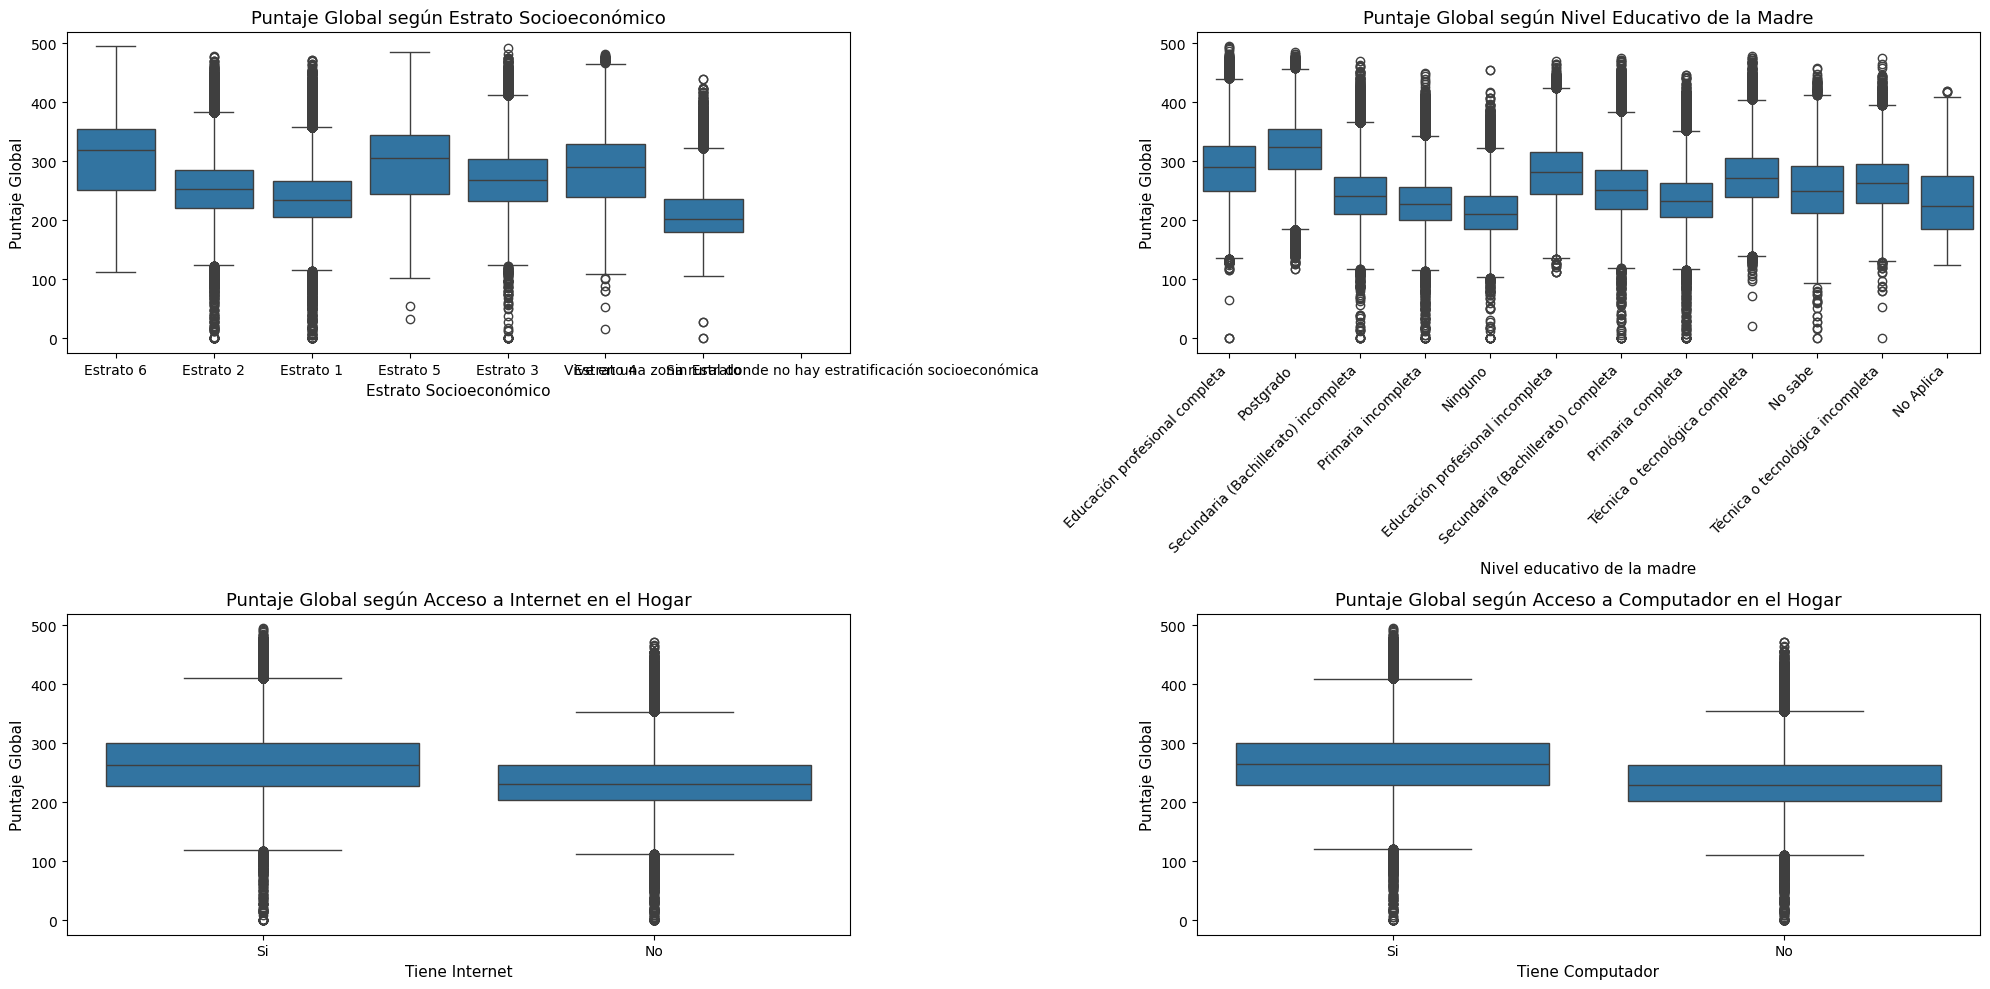

In [ ]:
plt.figure(figsize=(20, 10))

# Estrato socioeconómico
plt.subplot(2, 2, 1)
sns.boxplot(x='fami_estratovivienda', y='punt_global', data=saber11_df)
plt.title('Puntaje Global según Estrato Socioeconómico', fontsize=13)
plt.xlabel('Estrato Socioeconómico', fontsize=11)
plt.ylabel('Puntaje Global', fontsize=11)

# Educación de la madre
plt.subplot(2, 2, 2)
sns.boxplot(x='fami_educacionmadre', y='punt_global', data=saber11_df)
plt.title('Puntaje Global según Nivel Educativo de la Madre', fontsize=13)
plt.xlabel('Nivel educativo de la madre', fontsize=11)
plt.ylabel('Puntaje Global', fontsize=11)
plt.xticks(rotation=45, ha='right')

# Acceso a Internet
plt.subplot(2, 2, 3)
sns.boxplot(x='fami_tieneinternet', y='punt_global', data=saber11_df)
plt.title('Puntaje Global según Acceso a Internet en el Hogar', fontsize=13)
plt.xlabel('Tiene Internet', fontsize=11)
plt.ylabel('Puntaje Global', fontsize=11)

# Acceso a Computador
plt.subplot(2, 2, 4)
sns.boxplot(x='fami_tienecomputador', y='punt_global', data=saber11_df)
plt.title('Puntaje Global según Acceso a Computador en el Hogar', fontsize=13)
plt.xlabel('Tiene Computador', fontsize=11)
plt.ylabel('Puntaje Global', fontsize=11)

plt.tight_layout()
plt.show()


En la primera gráfica se observa una relación positiva entre el estrato socioeconómico y el puntaje global. Los estudiantes de estratos 5 y 6 presentan medianas de puntaje más altas, mientras que los de estrato 1 concentran valores más bajos. Esto sugiere que las condiciones socioeconómicas del hogar tienen una incidencia directa en el desempeño académico, posiblemente asociada al acceso a recursos educativos y entornos de aprendizaje más favorables.

En cuanto al nivel educativo de la madre, se evidencia una tendencia similar a mayor nivel de educación, mayor puntaje global. 
Los hijos de madres con educación técnica, profesional o posgrado tienden a ubicarse en rangos de puntaje más altos, mientras que los de madres con educación básica o primaria muestran distribuciones más bajas. Este patrón refuerza la idea de que el capital educativo familiar influye en las oportunidades de aprendizaje de los estudiantes.

Respecto al acceso a internet y a computador, ambos muestran diferencias claras en la mediana de puntajes. Los estudiantes que cuentan con estos recursos en casa tienden a obtener puntajes globales superiores, lo que destaca la importancia del acceso a herramientas tecnológicas como apoyo en los procesos de estudio y preparación.


### corelacion entre variables 

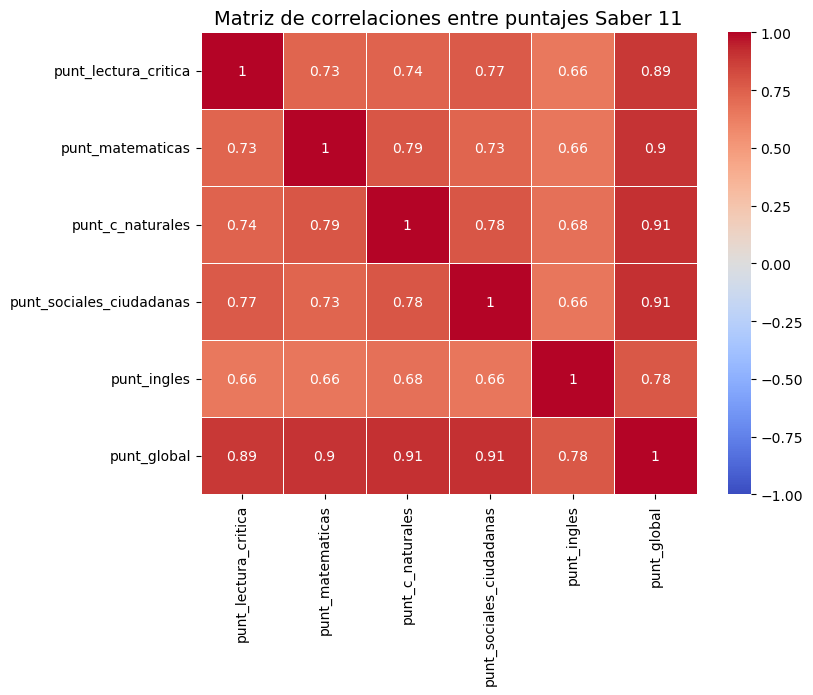

In [18]:

cols_interes = [
    'punt_lectura_critica',
    'punt_matematicas',
    'punt_c_naturales',
    'punt_sociales_ciudadanas',
    'punt_ingles',
    'punt_global'
]

correlaciones = saber11_df[cols_interes].corr()

plt.figure(figsize=(8,6))
sb.heatmap(correlaciones, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlaciones entre puntajes Saber 11', fontsize=14)
plt.show()


Las áreas evaluadas presentan correlaciones positivas y fuertes, lo que indica que el desempeño de los estudiantes tiende a ser coherente entre las distintas competencias.
Las relaciones más altas se observan entre Matemáticas, Ciencias Naturales y Sociales, que muestran patrones de rendimiento similares y una influencia directa sobre el puntaje global.

Por su parte, Inglés mantiene una correlación positiva pero algo menor, lo que sugiere que su desempeño puede depender de factores externos como el acceso a recursos o la exposición al idioma.

En conjunto, los resultados reflejan que un buen desempeño en una competencia suele ir acompañado de buenos resultados en las demás, evidenciando una base académica general consistente.

In [ ]:
# Crear variable objetivo binaria
umbral = 300
saber11_df['alto_desempeno'] = (saber11_df['punt_global'].astype(float) >= umbral).astype(int)

# Verificar proporciones
saber11_df['alto_desempeno'].value_counts(normalize=True)


alto_desempeno
0    0.883864
1    0.116136
Name: proportion, dtype: float64

In [ ]:
X = saber11_df[[
    'estu_edad_anios',
    'cole_area_ubicacion',
    'cole_caracter',
    'cole_naturaleza',
    'cole_calendario',
    'fami_educacionmadre',
    'fami_educacionpadre',
    'fami_estratovivienda',
    'fami_tieneinternet',
    'fami_tienecomputador'
]]

y = saber11_df['alto_desempeno']


In [ ]:
saber11_df.columns.tolist()


['periodo',
 'estu_tipodocumento',
 'estu_consecutivo',
 'cole_area_ubicacion',
 'cole_bilingue',
 'cole_calendario',
 'cole_caracter',
 'cole_cod_dane_establecimiento',
 'cole_cod_dane_sede',
 'cole_cod_depto_ubicacion',
 'cole_cod_mcpio_ubicacion',
 'cole_codigo_icfes',
 'cole_depto_ubicacion',
 'cole_genero',
 'cole_jornada',
 'cole_mcpio_ubicacion',
 'cole_naturaleza',
 'cole_nombre_establecimiento',
 'cole_nombre_sede',
 'cole_sede_principal',
 'estu_cod_depto_presentacion',
 'estu_cod_mcpio_presentacion',
 'estu_cod_reside_depto',
 'estu_cod_reside_mcpio',
 'estu_depto_presentacion',
 'estu_depto_reside',
 'estu_estadoinvestigacion',
 'estu_estudiante',
 'estu_fechanacimiento',
 'estu_genero',
 'estu_mcpio_presentacion',
 'estu_mcpio_reside',
 'estu_nacionalidad',
 'estu_pais_reside',
 'estu_privado_libertad',
 'fami_cuartoshogar',
 'fami_educacionmadre',
 'fami_educacionpadre',
 'fami_estratovivienda',
 'fami_personashogar',
 'fami_tieneautomovil',
 'fami_tienecomputador',
 'fam